# So what are we doing here?

We're training our reinforcement learning agent with an implicit world model that it can access indpendent of the model itself. 
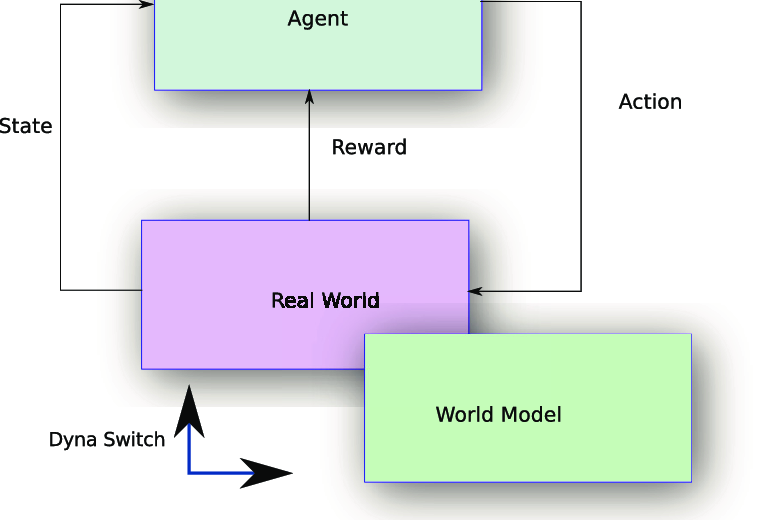

The effective strategy is as follows:
1. Rollout agent in environment
2. Train agent + world model on environment rollout
3. Rollout agent in world model
4. Train agent on world model rollout
5. Play with length of world model rollouts

There's a lot to play around with here. We could train the world model on a prior first which may be helpful. Lets suppose some small prior so our agent isn't awful to beign with.

What are we trying to capture?
So first, lets make clear that the experiment will run for 2000 rollouts on **the real environment** to make it consistent with the PPO training. 
Metrics:
1. Time it takes to complete training (how much more time, on average, are we subjecting the training to?) Let's note that sampling the fake environment can be rapidly parallelizable.
2. How fast does it train relative to rollouts on the real environment.

Next, let's define a couple parameters:
We'll define: 

$\tau \in \mathbb{N}$ as the world model look ahead number when generating samples for our agent. This has a max, naturally, of 200. 

$M \in \mathbb{N}$ as the number of "rollouts" we're taking from the world model in order to train it. Another way of thinking about this: suppose we wanted to train our consistently on 800 samples. Then we would run M rollouts of $\tau$ lookahead distance to gain enough samples to train the model. 

$\rho \in \mathbb{N}$ as the number of rollouts we're giving our world model to train via prior. 

# Experiments:

First things first, let's see if a PPO agent can train given samples from a trained world model at all. It should be able to, but let's actually test it out.

Once we do that, we can start to play with different rollout variations. How many samples are in the prior, etc.




# World Model Prior with Random Samples

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
from wm_ppo import PPO

In [2]:
import gym
rho = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")

In [3]:
old_obs = []
actions = []
new_obs = []
for _ in range(rho):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        old_obs.append(obs)
        actions.append(action)
        new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

old_obs = np.vstack(old_obs)
actions = np.vstack(actions)
new_obs = np.vstack(new_obs)

/home/tristongrayston/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
inputs = np.concatenate((old_obs, actions), axis=1)
inputs = torch.tensor(inputs)
outputs = torch.tensor(new_obs)
dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=64, shuffle=True, num_workers=4
)

In [5]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [6]:
out_features = 3
in_features = 4

wiring = AutoNCP(64, out_features)  

world_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=20,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

/home/tristongrayston/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 22.0 K | train
---------------------------------------
17.6 K    Trainable params
4.4 K     Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [138]:
# Agent
agent = PPO(
    ob_space=3,
    actions=1,
    n_batches=10,
    lam= 0.95,
    kl_coeff= 0.2,
    clip_rewards= False,
    clip_param= 0.2,
    vf_clip_param= 10.0,
    entropy_coeff= 0,
    a_lr= 5e-3,
    c_lr= 5e-3,
    device= 'cpu',
    max_ts= 100,
    rollouts_per_batch= 1,
    max_timesteps_per_episode= 200,
    n_updates_per_iteration= 3
)

mmm = torch.FloatTensor(old_obs)

mmmm = mmm[:2000]
mmmm.shape

torch.Size([2000, 3])

In [139]:
from tqdm import tqdm
batch = 200
num_epochs = 20000 // batch
for i in tqdm(range(1, num_epochs)):
    starts = mmm[(i-1)*batch:i*batch]
    pred_obs, pred_actions, rollout_adv, pred_returns, pred_log_probs, _ = get_wm_samples(agent, world_model, starts, 5)

    pred_obs = pred_obs.flatten(0, 1)
    pred_actions = pred_actions.flatten(0, 1)
    rollout_adv = rollout_adv.flatten(0, 1).view(-1, 1)
    pred_returns = pred_returns.flatten(0, 1).view(-1, 1)
    pred_log_probs = pred_log_probs.flatten(0, 1).view(-1, 1)

    agent.learn(1, pred_obs, pred_actions, rollout_adv, pred_returns, pred_log_probs, 0)

/tmp/ipykernel_216770/46076762.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_t = torch.tensor(state_t1, dtype=torch.float32)
100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [01:37<00:00,  1.02it/s]


In [140]:
pred_obs.shape

torch.Size([1000, 3])

In [122]:
b_obs, actions, advantages, returns, act_log_probs, ep_rewards = agent.rollout(env)
#print("")
#print(actions)

In [123]:
ep_rewards

[-1539.4191255827038]

In [21]:
from baseline import test_ppo

test_ppo(agent, "Pendulum-v1")

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (state_indep_ppo.py, line 185)

# Helper Functions for Training Loop

In [266]:
# first thing we have to do is define a reward function. I'll try to just straight up copy it
def angle_normalize(x):
    '''From the pendulum code '''
    return ((x + np.pi) % (2 * np.pi)) - np.pi

def compute_reward(state, action, max_torque=2.0):
    """
    Compute the reward for the Pendulum environment based on the state and action.
    
    The Pendulum environment calculates cost as:
        cost = angle_normalize(theta)**2 + 0.1 * theta_dot**2 + 0.001 * (torque**2)
    and returns the reward as:
        reward = -cost
    
    Parameters:
      state : array-like of shape (2,)
          The current state of the pendulum [theta, theta_dot].
      action : array-like or scalar
          The action to be applied (the torque), which will be clipped.
      max_torque : float
          The maximum allowed magnitude for the torque.
    
    Returns:
      reward : float
          The computed reward.

    what happens when off unit circle?
    """
    # Unpack the state.
    cos_theta = state[:, 0]
    sin_theta = state[:, 1]
    theta_dot = state[:, 2]
    
    # Recover theta from cos and sin.
    theta = np.arctan2(sin_theta, cos_theta)
    
    # Clip the action to the allowed range.
    clipped_action = np.clip(action, -max_torque, max_torque)
    if isinstance(clipped_action, np.ndarray):
        clipped_action = clipped_action[0]
    clipped_action = np.squeeze(clipped_action)
    
    # Compute the cost as defined.
    cost = angle_normalize(theta)**2 + 0.1 * theta_dot**2 + 0.001 * (clipped_action**2)
    reward = -cost
    return reward

def bootstrap_gaes_and_returns(model, last_state, rewards, values, gamma=0.99, lam=0.95):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/pdf/1506.02438.pdf
    """

    last_state_est = model.get_vf(last_state)

    batch_s = last_state.shape[0]

    #print(batch_s)
    
    zeros = np.zeros((1, batch_s, 1))
    next_values = np.concatenate([values[1:, :], zeros])
    
    next_values = next_values.squeeze()
    values = values.squeeze()
    
    #print("next_vals shape ", next_values.shape)
    #print("vals shape ",values.shape)
    #print("rews shape ",rewards.shape)
    
    #deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]
    deltas = rewards + gamma*next_values - values
    #deltas = torch.FloatTensor(deltas)
    #rewards = torch.FloatTensor(rewards)

    gaes = []
    rets = []

    gae = 0.0
    ret = 0.0
    
    for t in reversed(range(deltas.shape[0])):
        #td_res = rewards[t] + gamma * values[t + 1] - values[t] if t + 1 < len(values) else rewards[t] - values[t]
        gae = deltas[t] + gamma * tau * gae
        gaes.append(gae)

        ret = rewards[t] + gamma * ret
        rets.append(ret)

    
    gaes = np.stack(np.array(gaes[::-1]))
    rets = np.stack(np.array(rets[::-1]))
    
    return gaes, rets

def next_step_prediction(agent, wm, tau, start_states):
    b_obs = []
    actions = []
    advantages = []
    returns = []
    act_log_probs = []
    
    new_state = torch.tensor(start_states, dtype=torch.float32)
    states.append(new_state)
    for i in range(tau):
        
        action, log_prob = agent.get_action(new_state)
        vals = agent.get_vf(vect_obs)
        

In [262]:
# Sanity check: Does our reward function work?

residuals = []
for _ in range(rho):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)

        pred_rew = compute_reward(obs, action)

        #print(pred_rew, " vs real: ", reward)
        
        residuals.append(abs(pred_rew) - abs(reward))
   
    # Once the episode is done, close the environment
    env.close()

(-0.2, 0.2)

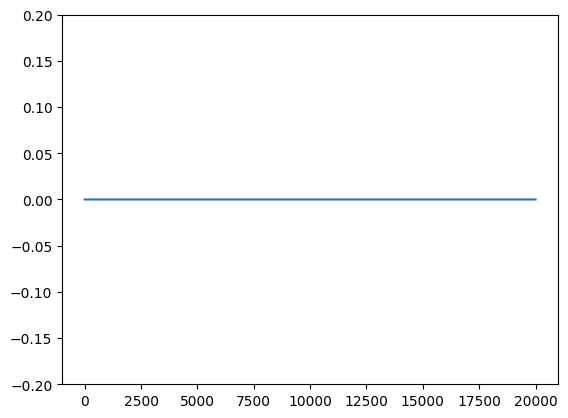

In [269]:
plt.plot(residuals)
plt.ylim(-0.2, 0.2)

In [143]:
# I would imagine state-independent variance would converge at higher rates, so let's start with that.

tau = 10

actionspace = env.action_space.shape[0]
obsspace = env.observation_space.shape[0]
print(f"actionspace: {actionspace}, obs space {obsspace}")
agent = PPO(
    ob_space=obsspace,
    actions=actionspace,
    n_batches=10,
    lam= 0.9,
    kl_coeff= 0.2,
    clip_rewards= False,
    clip_param= 0.2,
    vf_clip_param= 10.0,
    entropy_coeff= 0,
    a_lr= 5e-3,
    c_lr= 5e-3,
    device= 'cpu',
    max_ts= 100,
    rollouts_per_batch= 1,
    max_timesteps_per_episode= 200,
    n_updates_per_iteration= 3
)

actionspace: 1, obs space 3


## Test helper functions

In [144]:
# world model loop
def train_worldmodel(wm, input_states: np.array, output_states: np.array, trainer) -> None:
    ''' Only inputs we need here are input_states, actions, output_states '''
    #inputs = torch.concatenate((old_obs, actions), axis=1)
    #inputs = torch.tensor(inputs)
    #outputs = torch.tensor(new_obs)
    dataloader = data.DataLoader(
        data.TensorDataset(inputs, outputs), batch_size=64, shuffle=True, num_workers=4
    )
    trainer.fit(wm, dataloader)
    

def get_wm_samples(agent, wm, inputs: torch.tensor, tau: int):
    ''' 
    Getting world model samples for the purposes of updating agent.
        -input samples, 
        -push all samples in parallel to agent to get N-actions, 
        -next step via world model
        -calculate rewards
        -do this tau times. '''
    pred_obs = []
    pred_actions = []
    pred_rewards = []
    pred_values = []
    pred_log_probs = []

    state_t = inputs
    # Perform Rollout 
    for _ in range(tau):
        # Action
        
        actions, log_prob = agent.get_action(state_t, rollout=False)

        # temporarily, for debugging purposes
        actions = torch.FloatTensor(actions)

        vals = agent.get_vf(state_t)

        # predict next state
        state_t1, _ = wm(actions)

        # predict rewards
        rewards = compute_reward(state_t, actions)

        #print("costs shape:", rewards.shape)

        for dest_list, new_value in zip(
            (pred_obs, pred_actions, pred_rewards, pred_values, pred_log_probs),
            (state_t, actions, rewards, vals, log_prob)):

            #print("dest list$$$$: ", dest_list, "and now type ", type(dest_list))
            dest_list.append(new_value)

        state_t = torch.tensor(state_t1, dtype=torch.float32)
    
        # Get GAE, replacing values with advantages.

    pred_rewards = np.stack(pred_rewards)
    rollout_adv, returns = bootstrap_gaes_and_returns(agent, state_t, pred_rewards, np.array(pred_values))

    #print("Rollout SHape", rollout_adv.shape)

    # Get returns
    #ep_returns = self.discount_rewards(rollout_reward)
    #returns.append(ep_returns)

    # # turn things into tensors
    pred_obs = torch.stack(pred_obs, dim=0)
    
    pred_actions = np.stack(pred_actions, axis=0)  
    pred_actions = torch.FloatTensor(pred_actions)

    #advantages = torch.stack(advantages, dim=0)
    rollout_adv = torch.FloatTensor(rollout_adv)
    returns = torch.FloatTensor(returns)
    #advantages = advantages.view(-1, 1)

    pred_log_probs = np.stack(pred_log_probs, axis=0)  
    pred_log_probs = torch.FloatTensor(pred_log_probs)

    #returns = torch.stack(returns, dim=0)
    #returns = returns.view(-1, 1)

    #pred_log_probs = pred_log_probs.view(-1, 1)

    #print("Shape of pred_obs:", pred_obs.shape)
    #print("Shape of actions:", pred_actions.shape)
    #print("Shape of advantages:", rollout_adv.shape)
    #print("Shape of pred_log_probs:", np.shape(pred_log_probs))
    #print("Shape of returns:", returns.shape)


    return pred_obs, pred_actions, rollout_adv, returns, pred_log_probs, 0

In [145]:
# environment loop

new_inputs = old_obs[0: 200, :]
new_inputs.shape
new_inputs = torch.tensor(new_inputs, dtype=torch.float32)

In [146]:
# test get_wm_samples
pred_obs, pred_actions, adv, retrs, pred_log_probs, zero = get_wm_samples(agent, world_model, new_inputs, 3)

/tmp/ipykernel_216770/46076762.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_t = torch.tensor(state_t1, dtype=torch.float32)


In [147]:
pred_obs.shape

torch.Size([3, 200, 3])

In [154]:
# main training loop... oh boy

e = 100 # 100 epochs



for step in range(e):
    # get real samples
    b_obs, actions, advantages, returns, act_log_probs, ep_rewards = agent.rollout(env)

    print(ep_rewards)
    # train world model

    # There's a way to do this without redefining this, but the prototypes are allowed to be ugly.
    trainer = pl.Trainer(
        logger=pl.loggers.CSVLogger("log"),
        max_epochs=2,
        gradient_clip_val=1,  # Clip gradient to stabilize training
    )
    
    inputs = b_obs[0:199]
    starts = inputs
    rel_acts = actions[0:199]
    inputs = torch.concatenate((inputs, rel_acts), axis=1)
    outputs = b_obs[1:200]
    train_worldmodel(learn, inputs, outputs, trainer)

    # get samples
    pred_obs, pred_actions, rollout_adv, pred_returns, pred_log_probs, _ = get_wm_samples(agent, world_model, starts, 2)

    # i think i want to condense the tau-rollouts into one big batch
    pred_obs = pred_obs.flatten(0, 1)
    pred_actions = pred_actions.flatten(0, 1)
    rollout_adv = rollout_adv.flatten(0, 1).view(-1, 1)
    pred_returns = pred_returns.flatten(0, 1).view(-1, 1)
    pred_log_probs = pred_log_probs.flatten(0, 1).view(-1, 1)
    
    #print(pred_obs.shape)
    #print(pred_actions.shape)
    #print(rollout_adv.shape)
    #print(pred_returns.shape)
    #print(pred_log_probs.shape)

    # train model
    agent.learn(1, pred_obs, pred_actions, rollout_adv, pred_returns, pred_log_probs, 0)
    

/home/tristongrayston/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[-1629.4209258262483]


/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 22.0 K | train
---------------------------------------
17.6 K    Trainable params
4.4 K     Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                       | 0/? [00:00…


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Maybe PPO is the problem? See if we can use SAC to solve our issues. 

In [153]:
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3 import SAC

In [214]:
model = SAC("MlpPolicy", env, verbose=1)
model._setup_model()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [156]:
dir(model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_convert_train_freq',
 '_create_aliases',
 '_current_progress_remaining',
 '_custom_logger',
 '_dump_logs',
 '_episode_num',
 '_episode_storage',
 '_excluded_save_params',
 '_get_policy_from_name',
 '_get_torch_save_params',
 '_init_callback',
 '_last_episode_starts',
 '_last_obs',
 '_last_original_obs',
 '_n_updates',
 '_num_timesteps_at_start',
 '_on_step',
 '_sample_action',
 '_setup_learn',
 '_setup_lr_schedule',
 '_setup_model',
 '_stats_window_size',
 '_store_transition',
 '_total_timesteps',
 '_update_current_progress_remaining',
 '_update_inf

In [159]:
dir(model.replay_buffer)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_samples',
 '_maybe_cast_dtype',
 '_normalize_obs',
 '_normalize_reward',
 'action_dim',
 'action_space',
 'actions',
 'add',
 'buffer_size',
 'device',
 'dones',
 'extend',
 'full',
 'handle_timeout_termination',
 'n_envs',
 'next_observations',
 'obs_shape',
 'observation_space',
 'observations',
 'optimize_memory_usage',
 'pos',
 'reset',
 'rewards',
 'sample',
 'size',
 'swap_and_flatten',
 'timeouts',
 'to_torch']

In [160]:
model.replay_buffer.add()

TypeError: ReplayBuffer.add() missing 6 required positional arguments: 'obs', 'next_obs', 'action', 'reward', 'done', and 'infos'

In [239]:
# world model loop
def train_worldmodel(wm, input_states: np.array, output_states: np.array, trainer) -> None:
    ''' Only inputs we need here are input_states, actions, output_states '''
    #inputs = torch.concatenate((old_obs, actions), axis=1)
    #inputs = torch.tensor(inputs)
    #outputs = torch.tensor(new_obs)
    dataloader = data.DataLoader(
        data.TensorDataset(inputs, outputs), batch_size=64, shuffle=True, num_workers=4
    )
    trainer.fit(wm, dataloader)
    

def get_wm_samples_sac(agent, wm, inputs: torch.tensor, tau: int):
    ''' 
    Getting world model samples for the purposes of updating agent.
        -input samples, 
        -push all samples in parallel to agent to get N-actions, 
        -next step via world model
        -calculate rewards
        -do this tau times. '''
    pred_obs = []
    pred_nobs = []
    pred_actions = []
    pred_rewards = []
    pred_dones = []
    pred_infos = []

    state_t = inputs
    # Perform Rollout 
    for _ in range(tau):
        # Action
        
        actions = agent.predict(state_t)

        #print(type(actions[0]))

        # temporarily, for debugging purposes
        actions = torch.FloatTensor(actions[0])

        #vals = agent.get_vf(state_t)

        # predict next state
        state_t1, _ = wm(actions)
        state_t1 = state_t1.clone().detach()
        #print(state_t1.shape)

        # predict rewards
        rewards = compute_reward(state_t, actions)

        #print("costs shape:", rewards.shape)

        pred_dones.append(0)
        pred_infos.append([])

        for i in range(inputs.shape[0]):
            cur_state = state_t[i]
            n_state = state_t1[i]
            act = actions[i]
            rew = np.expand_dims(rewards[i], -1)

            #print(cur_state.shape, " ", n_state.shape, " ", act.shape, " ", rew.shape)
            
            agent.replay_buffer.add(state_t[i], state_t1[i], actions[i], rewards[i], np.array([0]), np.array([{}]))
            
        state_t = state_t1.clone()


In [231]:
# okay, maybe this can work
starts = mmm[1*batch:2*batch]
get_wm_samples_sac(model, world_model, starts, 5)

torch.Size([200, 3])
torch.Size([200, 3])
torch.Size([200, 3])
torch.Size([200, 3])
torch.Size([200, 3])


In [217]:
from stable_baselines3.common.logger import configure
model._logger = configure(folder="logs", format_strings=["stdout"])
model.train(-1)

In [232]:
model.train(-1)

In [236]:
obs, info = env.reset()

rewards = []

terminated = False
truncated = False
while terminated == False and truncated == False:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    #if terminated or truncated:
    #    obs, info = env.reset()
    rewards.append(reward)

sum(rewards)
    

-1196.1713966002512

In [282]:
#model.replay_buffer.sample(64, env=model._vec_normalize_env)

In [315]:
# now in one big loop
model = SAC("MlpPolicy", env, verbose=1)
model._setup_model()
model._logger = configure(folder="logs", format_strings=["stdout"])

ep_rewards = []
batch = 20
num_epochs = 20000 // batch
for i in range(1, num_epochs):
    starts = mmm[(i-1)*batch:i*batch]
    get_wm_samples_sac(model, world_model, starts, 10)
    model.train(-1)
    #print(model._n_updates)

    obs, info = env.reset()

    rewards = []
    
    terminated = False
    truncated = False
    while terminated == False and truncated == False:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        #if terminated or truncated:
        #    obs, info = env.reset()
        rewards.append(reward)
    
    ep_rewards.append(sum(rewards))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


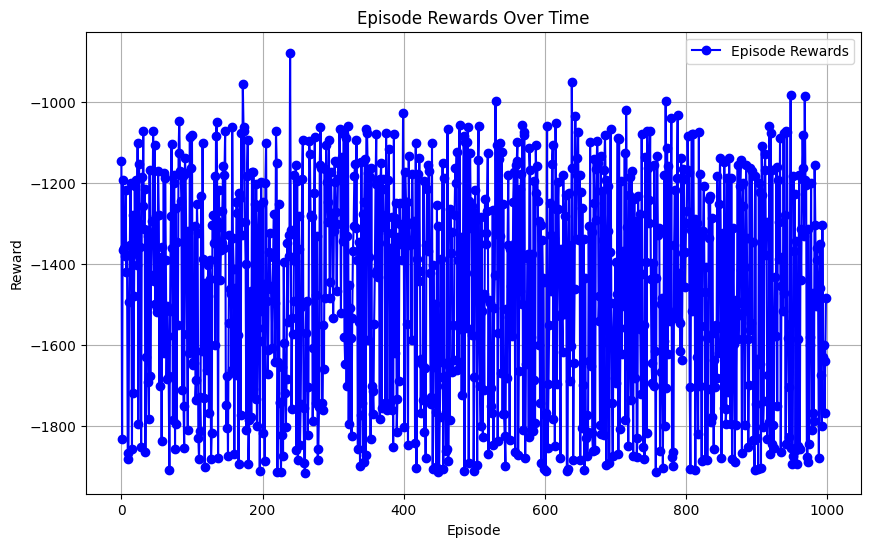

In [316]:
# Assuming ep_rewards is a list or NumPy array of floats
plt.figure(figsize=(10, 6))
plt.plot(ep_rewards, marker='o', linestyle='-', color='blue', label='Episode Rewards')
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

In [293]:
model = SAC("MlpPolicy", env, verbose=1)
model._setup_model()
model._logger = configure(folder="logs", format_strings=["stdout"])

model.learn(total_timesteps=10000, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.48e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 26        |
|    time_elapsed    | 29        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 23.9      |
|    critic_loss     | 0.238     |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.33     |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.47e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 23        |
|    time_elapsed    | 68        |
|    total_timesteps | 1600    

In [317]:
ep_rewards = []

obs, info = env.reset()

rewards = []

terminated = False
truncated = False
while terminated == False and truncated == False:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    #if terminated or truncated:
    #    obs, info = env.reset()
    rewards.append(reward)

sum(rewards)

-1379.1119611423794